## **Import Libaries**

In [1]:
!pip install opencv-python-headless

import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import kagglehub


# **Dataset Download**

In [2]:
import kagglehub
dataset = kagglehub.dataset_download('ashishsaxena2209/animal-image-datasetdog-cat-and-panda')
print('Images download done.')

Images download done.


# **Image Categories**

In [3]:
image_dir = '/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals'
Categories = []
for c in os.listdir(image_dir):
    Categories.append(c)
print(Categories)

['dogs', 'panda', 'cats']


In [4]:
train_data = []
IMG_SIZE = 32
for c in Categories:
    path = os.path.join(image_dir,c)
    class_num = Categories.index(c)
    for img in tqdm(os.listdir(path)):
      try:
          img_arr = cv2.imread(os.path.join(path,img))
          img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
          train_data.append([img_arr, class_num])
      except WException as e:
            pass

print(len(train_data))

100%|██████████| 1000/1000 [00:06<00:00, 145.10it/s]

3000


# **Display Randomly Selected Photo & Converting It to grey scale**

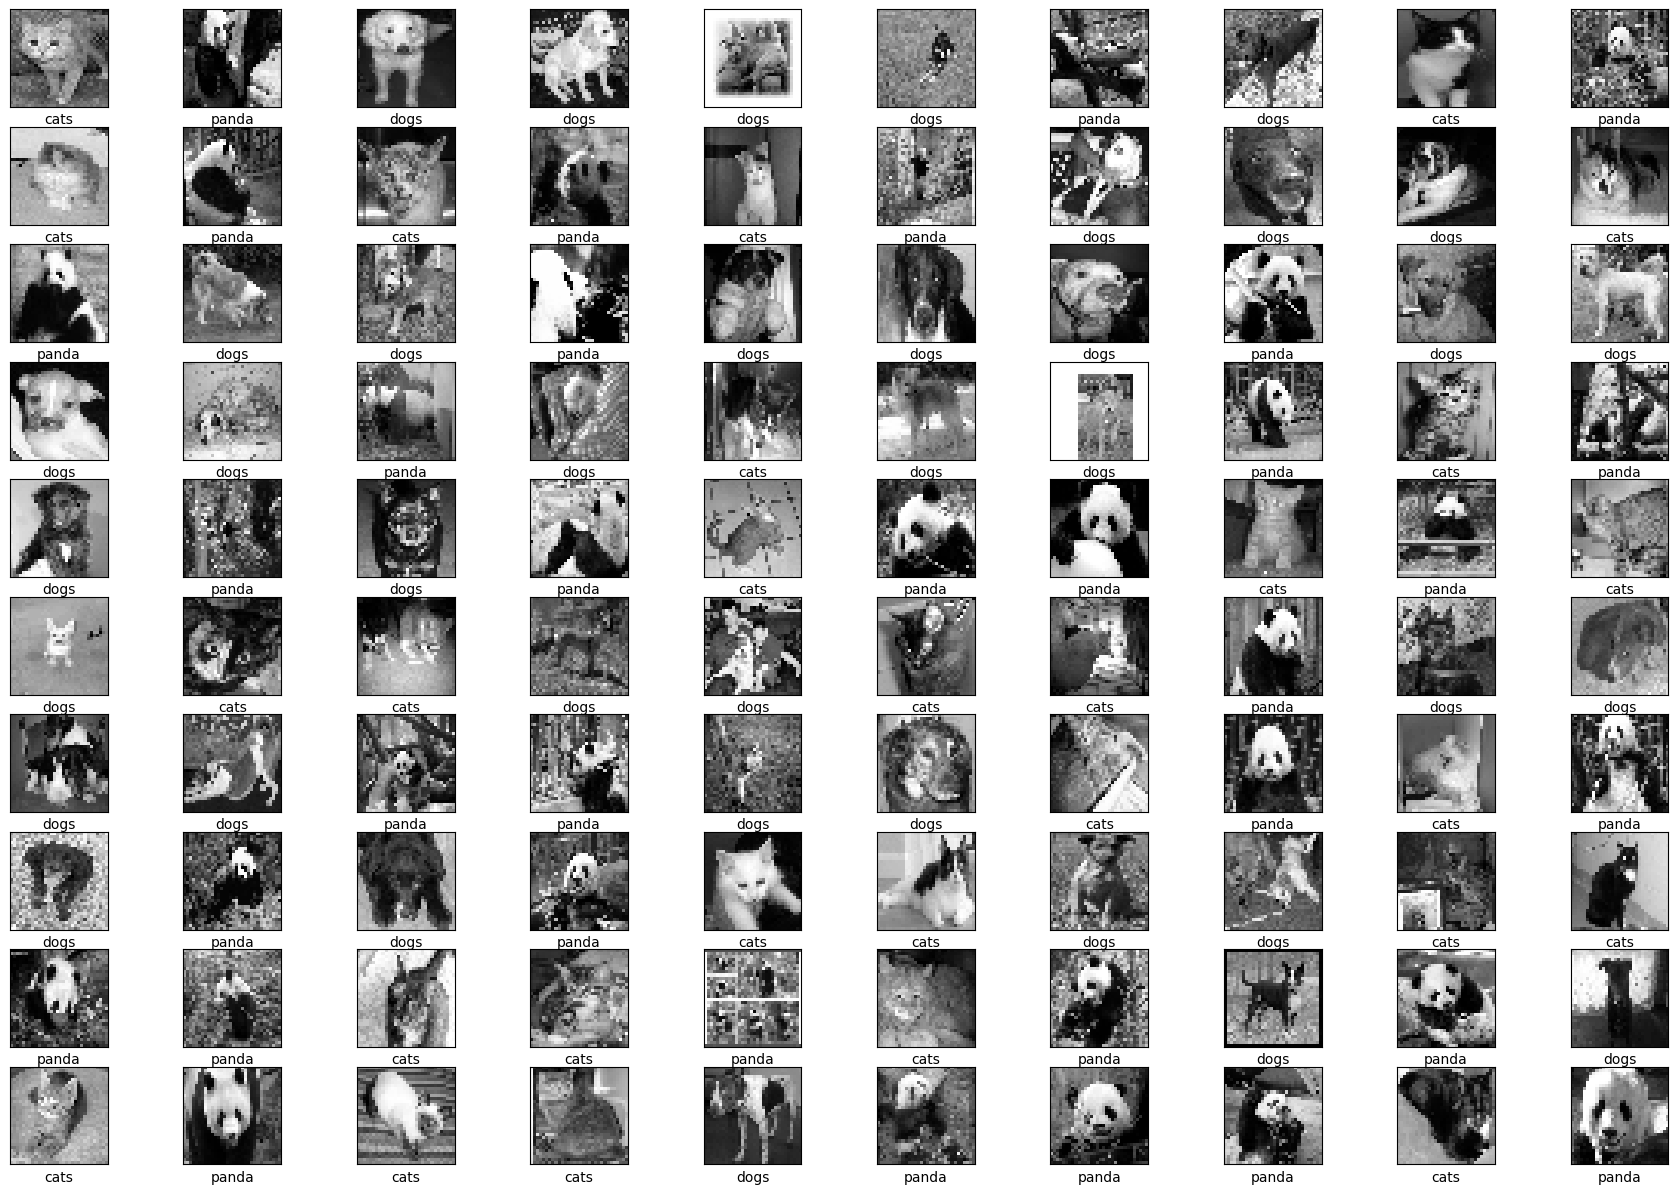

In [5]:
random.shuffle(train_data)
plt.figure(figsize=(22,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    image = train_data[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(Categories[train_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==100:
        break
plt.show()

# **Training**

In [13]:
# Dividing the dataset into 5 separate folds
f0 = train_data[0:600]
f1 = train_data[600:1200]
f2 = train_data[1200:1800]
f3 = train_data[1800:2400]
f4 = train_data[2400:3000]

In [14]:
# Functions for collecting l1 & l2 distances respectively
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))


In [15]:
# Defining the metric to sort a list based on it's 3rd index
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]


In [16]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_distance, "l2": l2_distance}])

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]


In [21]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1

            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # in case of a tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))


    return k_accuracies




In [22]:
dist_by_fold = []
import math
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4

    dist_by_fold.append(distance_calc(train, validation))


100%|██████████| 600/600 [00:25<00:00, 23.17it/s]


In [23]:
len(dist_by_fold[0][0])

600

In [29]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])



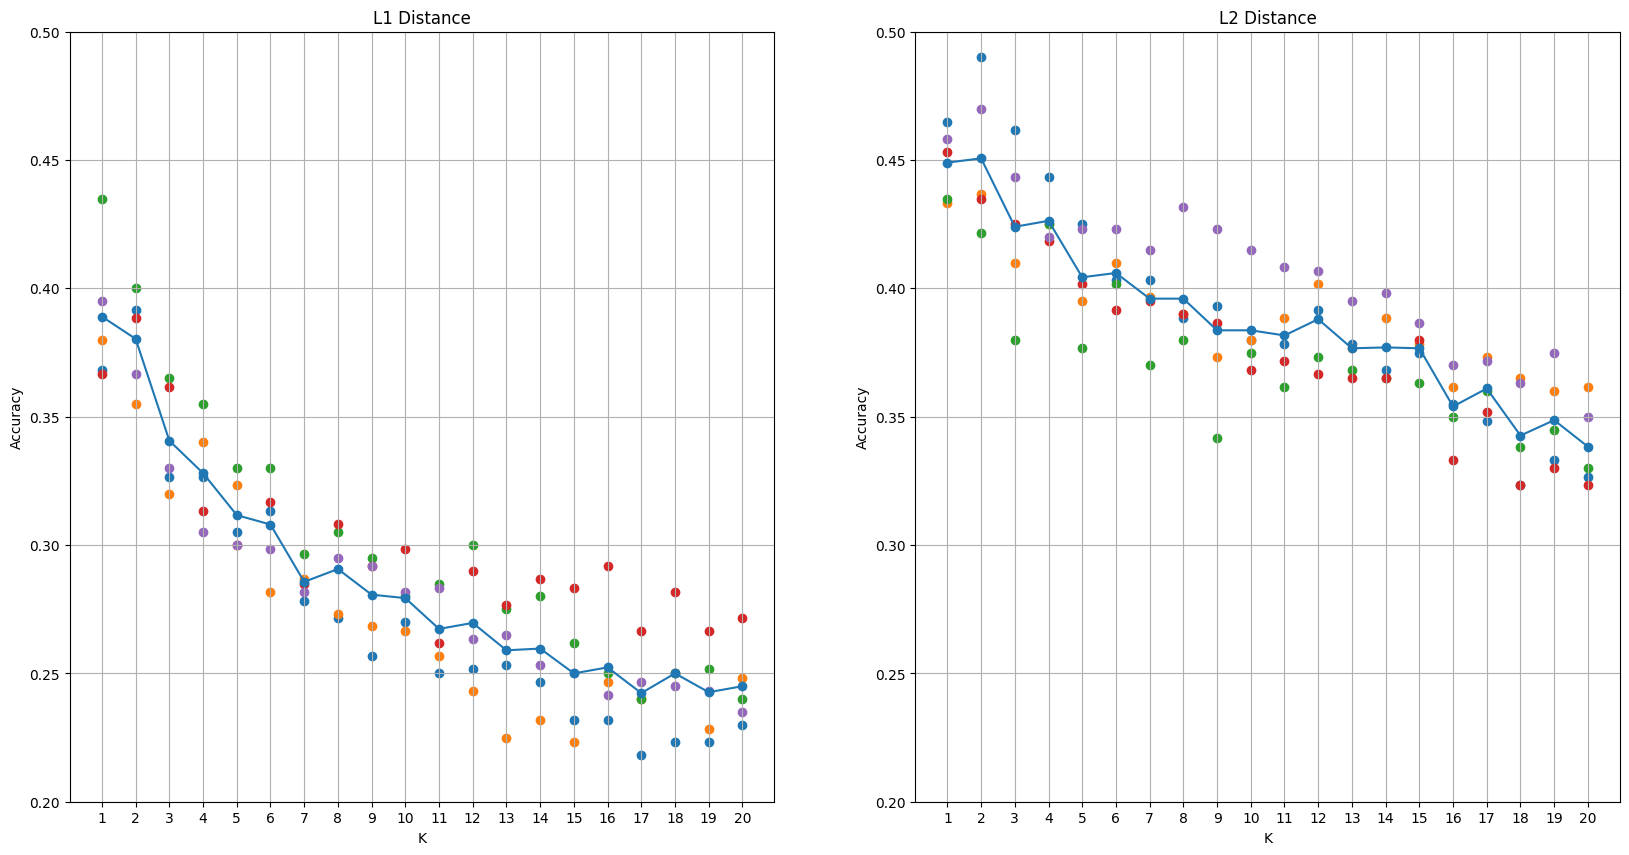

In [26]:
# l1 distance accuracy plot

x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)

# l2 distance accuracy plot
x_list = list(range(1, k_range+1))

plt.subplot(1,2,2)
for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)
plt.show()

# **Discussion**

The visualization presents a comparative analysis of L1 (Manhattan) and L2 (Euclidean) distance metrics across five cross-validation folds for a K-nearest neighbors classifier applied to animal image classification. The left graph tracks L1 distance performance while the right graph displays L2 distance results, both plotted against K values ranging from 1 to 20. Each colored point represents a specific fold's accuracy at a given K value, with the blue line indicating the average performance across all folds. The graphs effectively illustrate how classification accuracy changes with different neighborhood sizes and distance calculations, revealing distinct performance patterns between the two metrics. This fold-by-fold approach provides deeper insights into the model's stability and optimal configuration than aggregate measures alone would offer.


---


**Accuracy:**
The accuracy comparison between L1 and L2 distance metrics reveals significant performance differences. With L1 distance, accuracy peaks around 0.43-0.44 at K=1 before steadily declining to below 0.25 as K increases beyond 15. This steep downward trajectory suggests that Manhattan distance becomes increasingly unreliable with larger neighborhood sizes. In contrast, L2 distance demonstrates superior performance throughout, achieving maximum accuracy of approximately 0.48-0.49 at K=2 and maintaining relatively stable performance above 0.35 even at higher K values. The more gradual accuracy decline with Euclidean distance indicates it better captures the underlying structure of the image data. Notably, both metrics show consistency across the five folds, with L2 exhibiting slightly more inter-fold variability in the mid-range K values (K=3 to K=15). This consistency suggests the cross-validation approach is robust, while the clear performance advantage of L2 over L1 provides strong evidence for selecting Euclidean distance with small K values (preferably K=2) as the optimal configuration.


---


**Limitations:**
Despite the clear insights provided, this analysis faces several limitations that should be acknowledged. First, the overall accuracy remains relatively low (below 0.50) even with the best configuration, suggesting that a simple KNN approach may be insufficient for this complex image classification task. Second, the dataset size of only 3,000 images (600 per fold) may be too small to fully represent the variability in animal appearances, potentially limiting generalizability. Third, the use of downscaled 32x32 pixel images likely results in significant loss of discriminative features that could improve classification. The analysis also doesn't address potential improvements from image preprocessing techniques, feature extraction methods, or weighted voting schemes that might enhance KNN performance. Additionally, the evaluation focuses solely on accuracy without considering other important metrics like precision, recall, or F1-score, which could reveal class-specific performance issues, particularly if the dataset is imbalanced. Finally, the study is limited to just two distance metrics, overlooking other potentially effective measures like cosine similarity or Mahalanobis distance that might better capture the relationship between image features.

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'panda' with L1 distance 0.00
Prediction 2: Class 'dogs' with L1 distance 937.47
Prediction 3: Class 'dogs' with L1 distance 937.90
Prediction 4: Class 'panda' with L1 distance 943.16
Prediction 5: Class 'dogs' with L1 distance 944.17

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'panda' with L2 distance 0.00
Prediction 2: Class 'panda' with L2 distance 310.31
Prediction 3: Class 'panda' with L2 distance 311.16
Prediction 4: Class 'panda' with L2 distance 311.73
Prediction 5: Class 'cats' with L2 distance 311.80


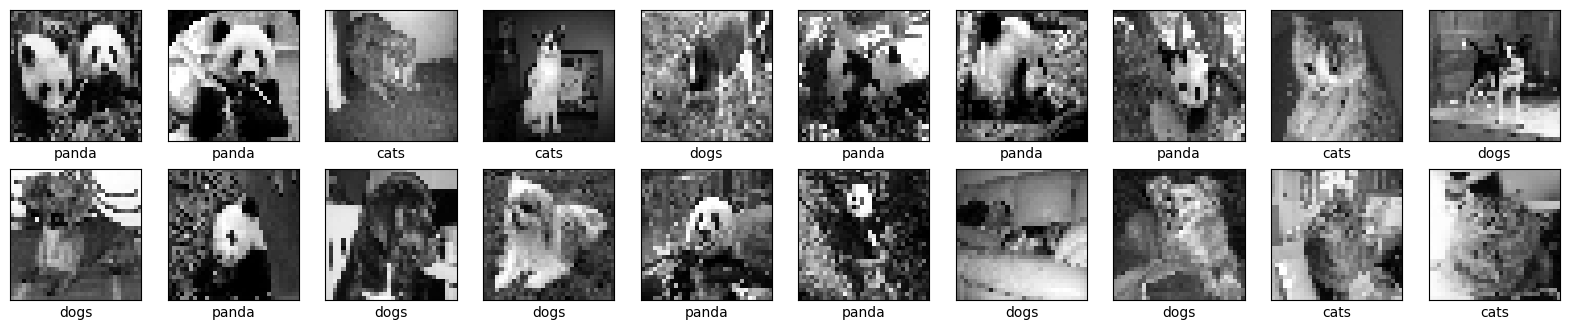

In [27]:
random.shuffle(train_data)

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(5, 10, i+1)
    image = train_data[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(Categories[train_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 19:
        break

test_images = []

for i in range(3000):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])

    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    break

Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'cats': [2, np.float64(624.6205151723168)]}
max number of at common class: 2
highest probable class: ['cats']


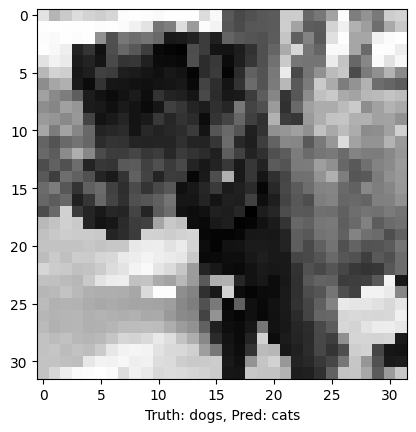



Classes with their number of occurances: {'panda': [3, np.float64(628.0754732334877)]}
max number of at common class: 3
highest probable class: ['panda']


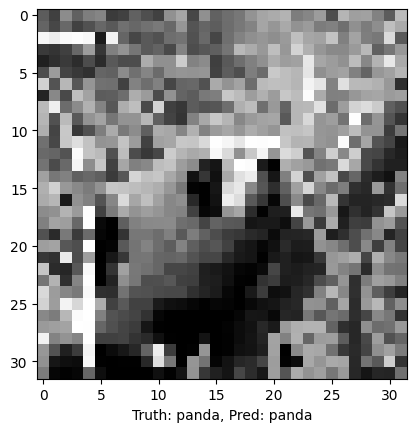



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'cats': [2, np.float64(621.169820789114)]}
max number of at common class: 2
highest probable class: ['cats']


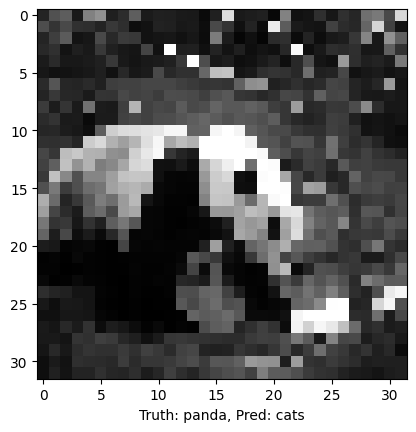



Classes with their number of occurances: {'cats': [1, np.float64(0.0)], 'dogs': [1, np.float64(313.7004941022567)], 'panda': [1, np.float64(314.5282181299478)]}
max number of at common class: 1
highest probable class: ['cats', 'dogs', 'panda']
Class with the least error: (['cats'], np.float64(0.0))


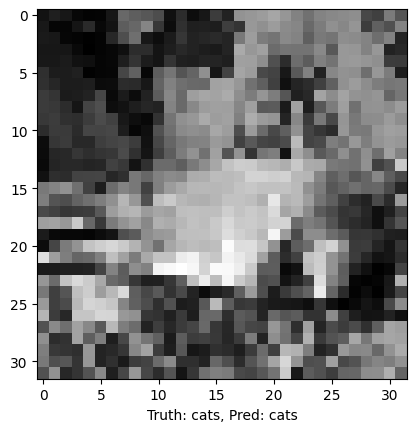



Classes with their number of occurances: {'panda': [3, np.float64(615.7943833300344)]}
max number of at common class: 3
highest probable class: ['panda']


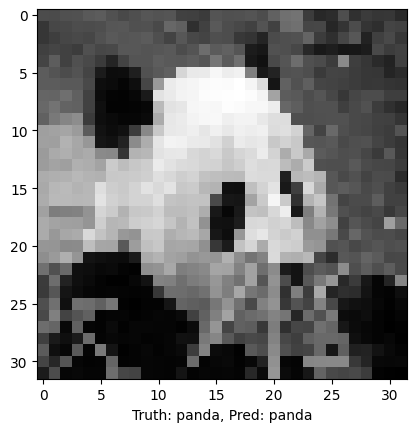



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'dogs': [2, np.float64(606.7962270052291)]}
max number of at common class: 2
highest probable class: ['dogs']


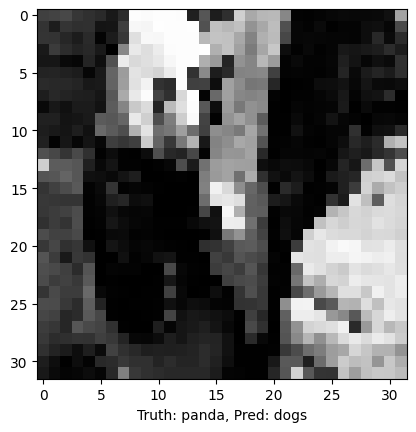



Classes with their number of occurances: {'cats': [1, np.float64(0.0)], 'panda': [1, np.float64(309.8209160143969)], 'dogs': [1, np.float64(310.795752866734)]}
max number of at common class: 1
highest probable class: ['cats', 'panda', 'dogs']
Class with the least error: (['cats'], np.float64(0.0))


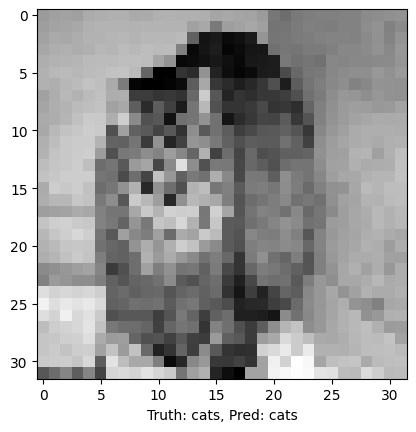



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'cats': [2, np.float64(606.0570816801527)]}
max number of at common class: 2
highest probable class: ['cats']


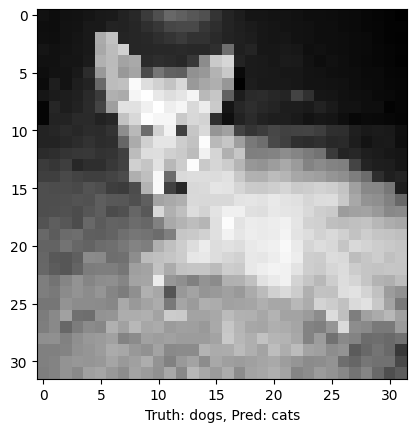



Classes with their number of occurances: {'dogs': [2, np.float64(309.98870947181285)], 'panda': [1, np.float64(308.51418119755857)]}
max number of at common class: 2
highest probable class: ['dogs']


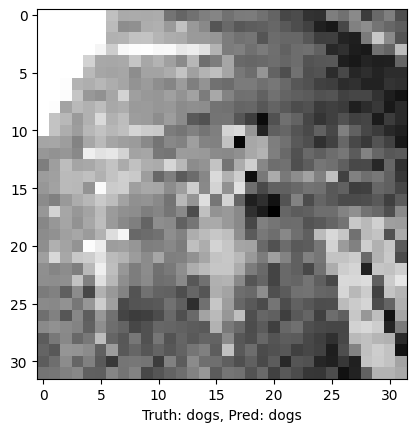



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'cats': [1, np.float64(307.96590720402804)], 'dogs': [1, np.float64(307.97727188868987)]}
max number of at common class: 1
highest probable class: ['panda', 'cats', 'dogs']
Class with the least error: (['panda'], np.float64(0.0))


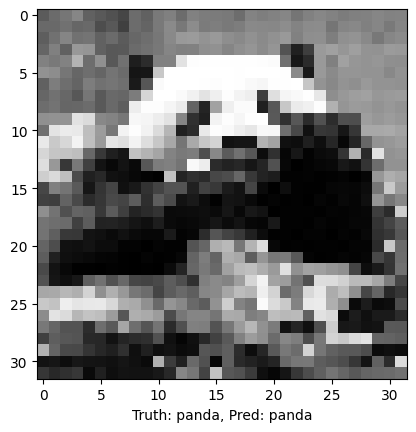



Classes with their number of occurances: {'panda': [2, np.float64(308.26287483250394)], 'dogs': [1, np.float64(309.2862751562054)]}
max number of at common class: 2
highest probable class: ['panda']


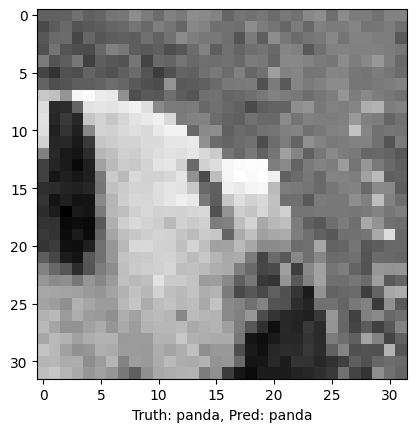



Classes with their number of occurances: {'panda': [2, np.float64(312.0705048542717)], 'cats': [1, np.float64(312.9488776142199)]}
max number of at common class: 2
highest probable class: ['panda']


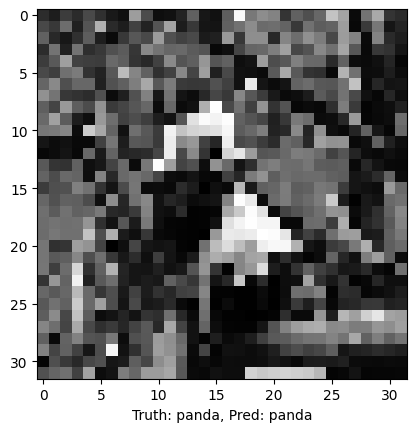



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'panda': [1, np.float64(298.068784007987)], 'cats': [1, np.float64(300.08498796174393)]}
max number of at common class: 1
highest probable class: ['dogs', 'panda', 'cats']
Class with the least error: (['dogs'], np.float64(0.0))


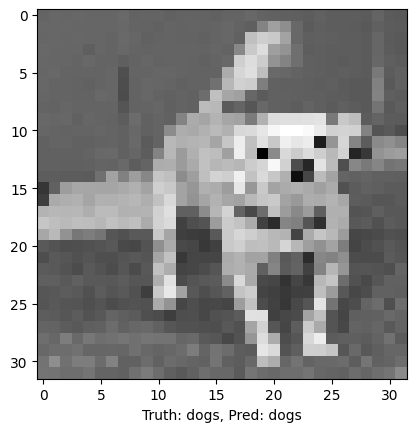



Classes with their number of occurances: {'dogs': [3, np.float64(605.4564708035703)]}
max number of at common class: 3
highest probable class: ['dogs']


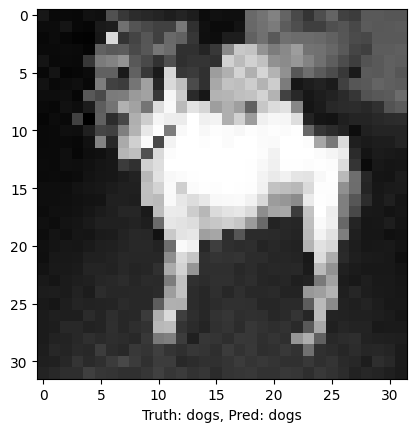



Classes with their number of occurances: {'cats': [3, np.float64(612.2872451658955)]}
max number of at common class: 3
highest probable class: ['cats']


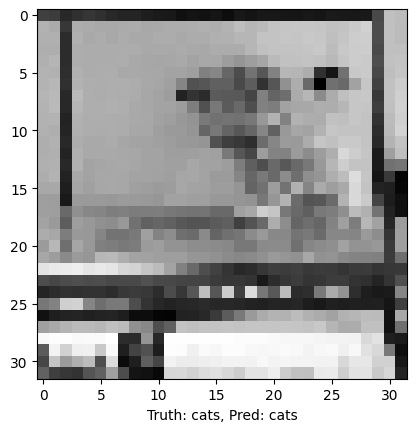



Classes with their number of occurances: {'panda': [3, np.float64(623.9455154948173)]}
max number of at common class: 3
highest probable class: ['panda']


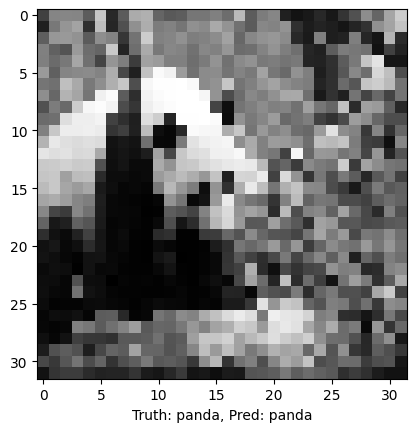



Classes with their number of occurances: {'cats': [3, np.float64(571.1353432533627)]}
max number of at common class: 3
highest probable class: ['cats']


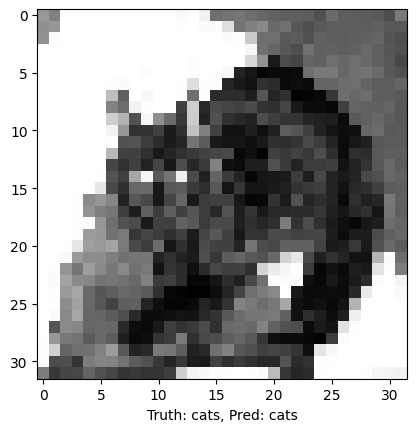



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'dogs': [2, np.float64(620.2435000990592)]}
max number of at common class: 2
highest probable class: ['dogs']


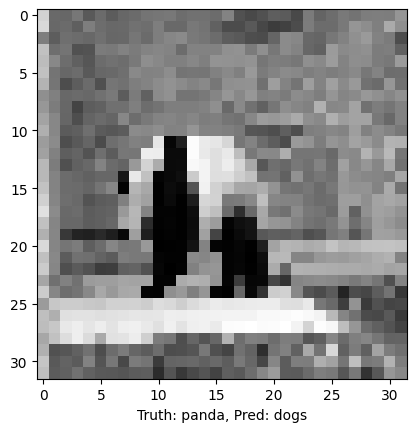



Classes with their number of occurances: {'cats': [2, np.float64(283.963025762158)], 'dogs': [1, np.float64(292.612371577143)]}
max number of at common class: 2
highest probable class: ['cats']


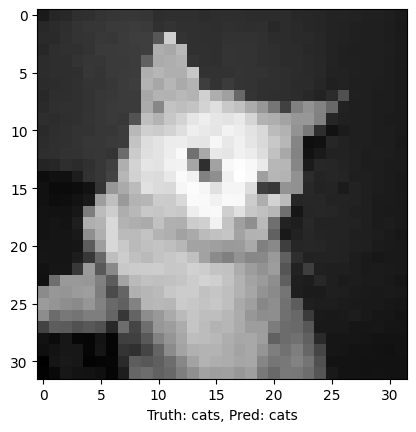



Classes with their number of occurances: {'cats': [2, np.float64(310.34819155264944)], 'dogs': [1, np.float64(308.82681230748085)]}
max number of at common class: 2
highest probable class: ['cats']


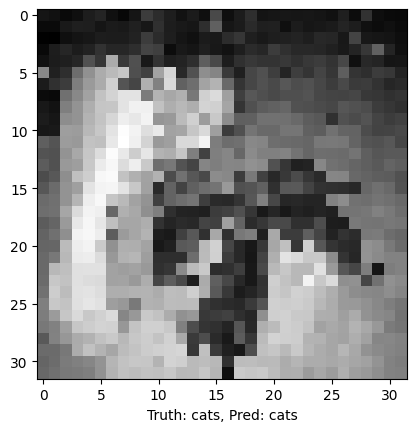



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'cats': [2, np.float64(611.0739826462025)]}
max number of at common class: 2
highest probable class: ['cats']


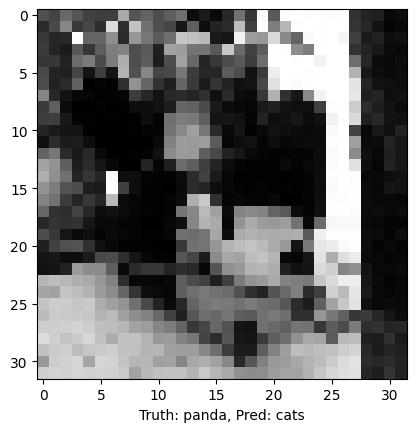



Classes with their number of occurances: {'cats': [1, np.float64(0.0)], 'panda': [2, np.float64(621.3470168550695)]}
max number of at common class: 2
highest probable class: ['panda']


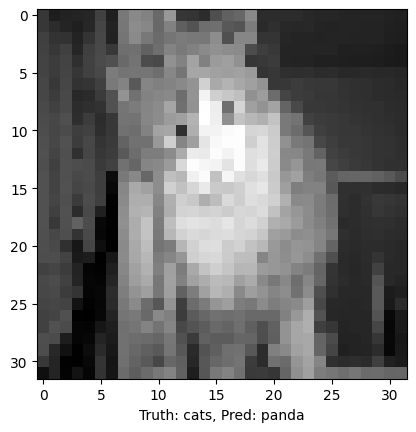



Classes with their number of occurances: {'dogs': [2, np.float64(310.789317705741)], 'cats': [1, np.float64(308.5368697578946)]}
max number of at common class: 2
highest probable class: ['dogs']


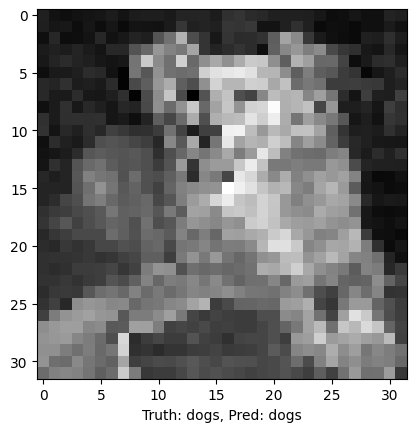



Classes with their number of occurances: {'dogs': [2, np.float64(313.9347065872138)], 'cats': [1, np.float64(313.85824825866854)]}
max number of at common class: 2
highest probable class: ['dogs']


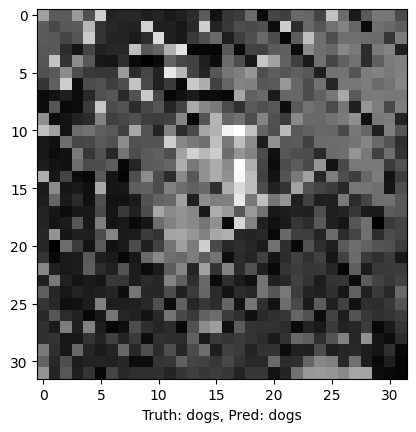



Classes with their number of occurances: {'cats': [3, np.float64(583.3594459694327)]}
max number of at common class: 3
highest probable class: ['cats']


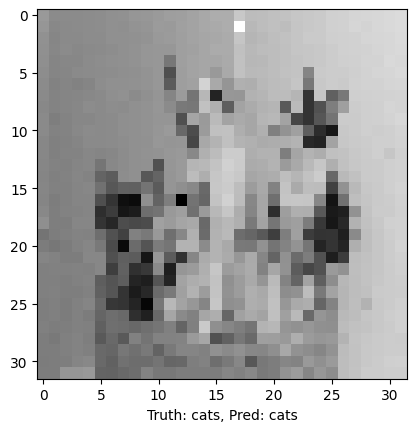



Classes with their number of occurances: {'cats': [3, np.float64(608.0914498764114)]}
max number of at common class: 3
highest probable class: ['cats']


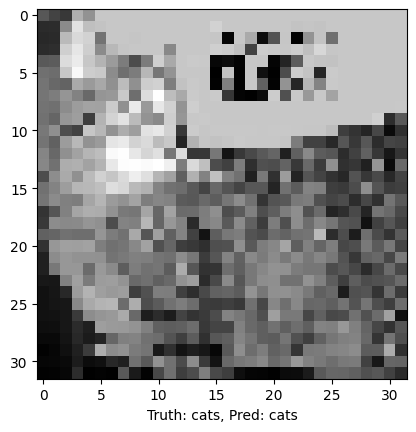



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'panda': [1, np.float64(310.99196131089946)], 'cats': [1, np.float64(311.0851973334636)]}
max number of at common class: 1
highest probable class: ['dogs', 'panda', 'cats']
Class with the least error: (['dogs'], np.float64(0.0))


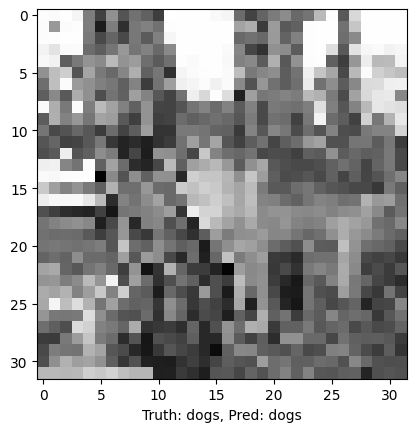



Classes with their number of occurances: {'cats': [1, np.float64(0.0)], 'dogs': [1, np.float64(307.89121455475146)], 'panda': [1, np.float64(308.86081007470017)]}
max number of at common class: 1
highest probable class: ['cats', 'dogs', 'panda']
Class with the least error: (['cats'], np.float64(0.0))


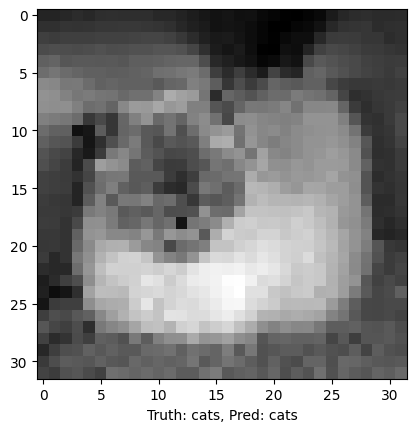



Classes with their number of occurances: {'cats': [1, np.float64(0.0)], 'dogs': [1, np.float64(310.86653084563477)], 'panda': [1, np.float64(312.00480765526675)]}
max number of at common class: 1
highest probable class: ['cats', 'dogs', 'panda']
Class with the least error: (['cats'], np.float64(0.0))


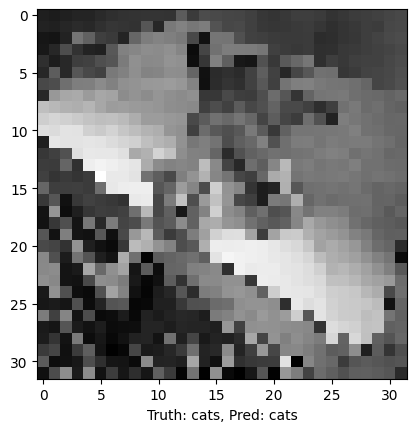



Classes with their number of occurances: {'cats': [2, np.float64(291.57160355562746)], 'dogs': [1, np.float64(295.56217619986495)]}
max number of at common class: 2
highest probable class: ['cats']


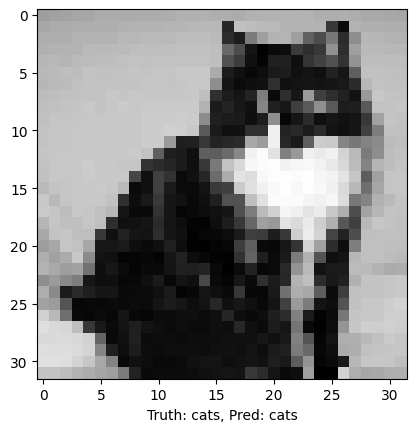



Classes with their number of occurances: {'cats': [2, np.float64(310.79092650848094)], 'panda': [1, np.float64(310.45611606151357)]}
max number of at common class: 2
highest probable class: ['cats']


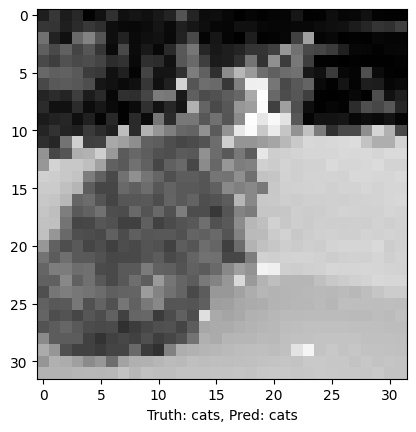



Classes with their number of occurances: {'panda': [2, np.float64(315.8559798389133)], 'dogs': [1, np.float64(315.2459357390671)]}
max number of at common class: 2
highest probable class: ['panda']


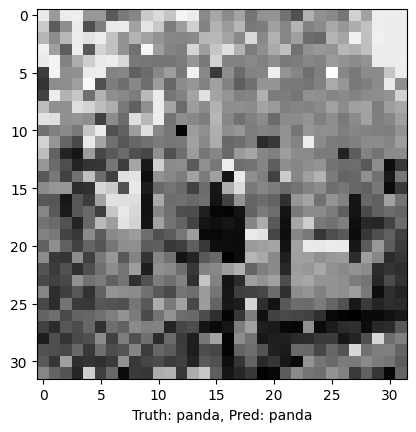



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'panda': [2, np.float64(617.7591140297613)]}
max number of at common class: 2
highest probable class: ['panda']


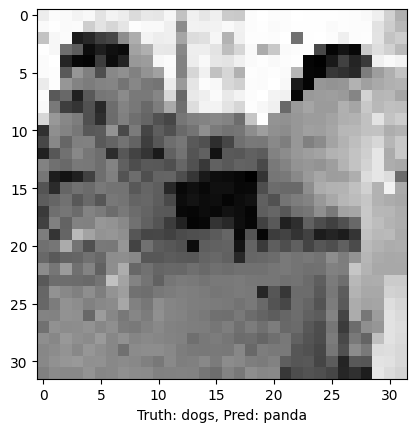



Classes with their number of occurances: {'dogs': [2, np.float64(309.89030317194505)], 'cats': [1, np.float64(311.9759606123523)]}
max number of at common class: 2
highest probable class: ['dogs']


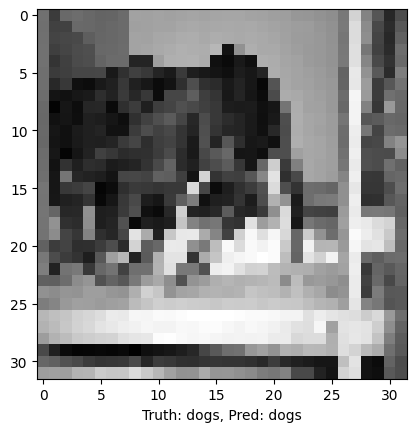



Classes with their number of occurances: {'cats': [2, np.float64(313.65905056286834)], 'panda': [1, np.float64(313.6718030043504)]}
max number of at common class: 2
highest probable class: ['cats']


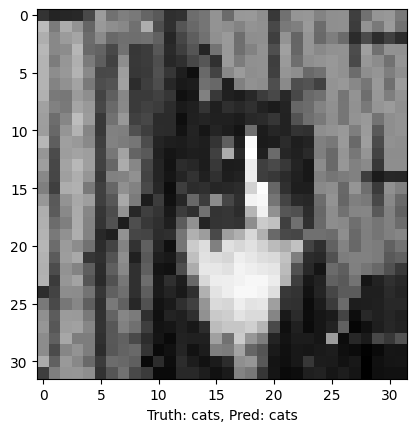



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'cats': [2, np.float64(607.191637461571)]}
max number of at common class: 2
highest probable class: ['cats']


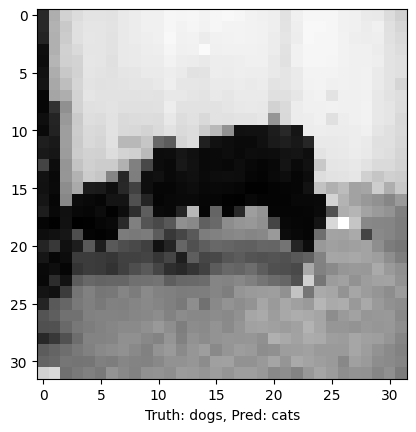



Classes with their number of occurances: {'panda': [2, np.float64(313.6781790306747)], 'dogs': [1, np.float64(311.1173412074615)]}
max number of at common class: 2
highest probable class: ['panda']


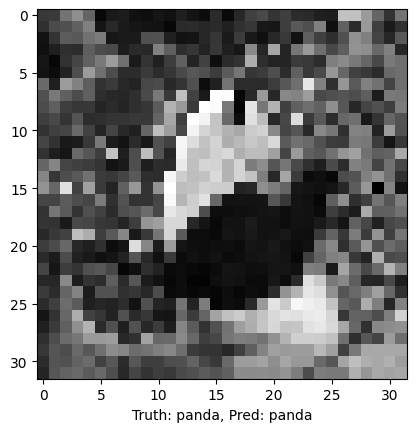



Classes with their number of occurances: {'panda': [1, np.float64(0.0)], 'dogs': [1, np.float64(310.0596716762759)], 'cats': [1, np.float64(310.56561303531333)]}
max number of at common class: 1
highest probable class: ['panda', 'dogs', 'cats']
Class with the least error: (['panda'], np.float64(0.0))


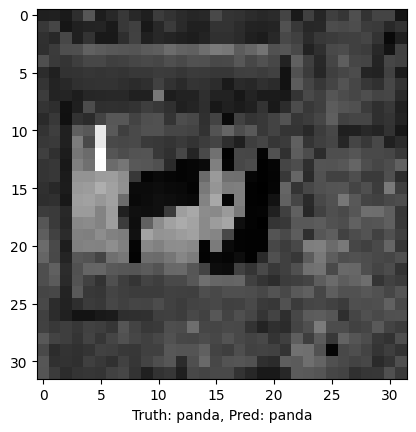



Classes with their number of occurances: {'dogs': [1, np.float64(0.0)], 'panda': [1, np.float64(300.6709164518577)], 'cats': [1, np.float64(301.6869238134129)]}
max number of at common class: 1
highest probable class: ['dogs', 'panda', 'cats']
Class with the least error: (['dogs'], np.float64(0.0))


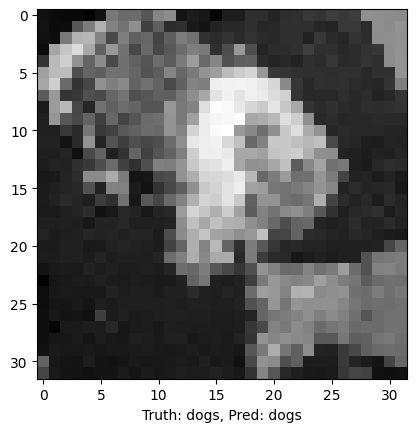



Classes with their number of occurances: {'cats': [3, np.float64(614.3402831198534)]}
max number of at common class: 3
highest probable class: ['cats']


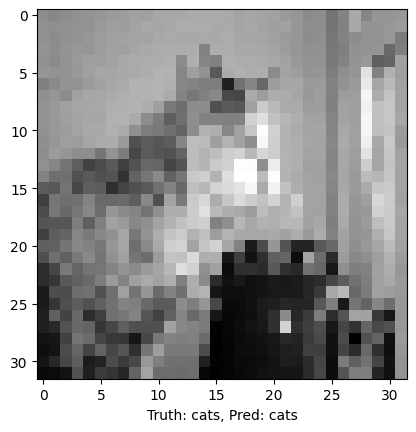



Correctly predicted 31 images out of 40, overall accuracy: 77.5 %


In [28]:
random.shuffle(train_data)

test_images = []
neighbours = 3
test_count = 40

for i in range(test_count):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, train_data[i][1]])

accurate = 0

for test_image_gray in test_images:
    distances2 = []
    pred = None
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    prediction_classes = [[cl[0], Categories[cl[1]]] for cl in distances2[:neighbours]]
    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}
    for pc in prediction_classes:
      if pc[1] in occurrences_dict:
          occurrences_dict[pc[1]][0] = occurrences_dict[pc[1]][0] + 1
          occurrences_dict[pc[1]][1] += pc[0]
      else:
          occurrences_dict[pc[1]][0] = 1
          occurrences_dict[pc[1]][1] += pc[0]

    print(f'Classes with their number of occurances: {occurrences_dict}')

    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)
    print(f'max number of at common class: {max_count_0}')

    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]
    print(f'highest probable class: {keys_with_max_value}')

    if len(keys_with_max_value) == 1:
      pred = keys_with_max_value[0]
    else:
      elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
      min_count_1 = min(elements_at_index_1)

      keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
      pred = keys_with_min_value[0]
      print(f'Class with the least error: {keys_with_min_value, min_count_1}')

    #print(pred)

    truth = Categories[test_image_gray[1]]
    plt.figure()
    plt.imshow(test_image_gray[0], cmap="gray")
    plt.xlabel(f"Truth: {truth}, Pred: {pred}")
    plt.show()
    if truth == pred: accurate += 1
    for i in range(2): print()


    #break

print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')